Ноутбук создан в google colab, использовать лучше T4 (в пункте среда выполнения -> сменить среду выполнения)

# Мультимодальный RAG -- пример с RuTube и русским языком

Эмбеддинги будем брать [CLIP](https://github.com/openai/CLIP)


In [ ]:
%pip install -q -U jedi
%pip install -q faiss-cpu
%pip install -q -U openai-whisper
%pip install -q git+https://github.com/openai/CLIP.git
%pip install -q torch torchvision
%pip install -q moviepy
%pip install -q pydub
%pip install -q ffmpeg-python
%pip install -q soundfile
%pip install -q yt-dlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 13.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s e

In [ ]:
from moviepy.editor import VideoFileClip
from pathlib import Path
from pprint import pprint
import os
import yt_dlp
import whisper
from PIL import Image
import matplotlib.pyplot as plt
import json

  if event.key is 'enter':



# 1. Подготовим видео

#### Укажем видео и пути для сохранения файлов

In [ ]:
video_url = "https://rutube.ru/video/71b79e2612b5c1ee6c47d32921d27cf4/?playlist=121010"
output_video_path = "./video_data/"
output_folder = "/content/"
output_audio_path = "/content/output_audio.wav"
images_path = "/content/images"
filepath = output_video_path + "input_vid.mp4"
Path(output_folder).mkdir(parents=True, exist_ok=True)
freq = 1 # кадров в сек
fps_interval = freq
context_window = 3

#### Скачаем видео, нарежем на кадры, вытащим звуковую дорожку и переведем ее в текст

In [ ]:
ydl_opts = {'outtmpl': filepath}
with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    ydl.download([video_url])
    info = ydl.extract_info(video_url, download=False)
    metadata_vid = {
            "Author": info.get('uploader', 'Unknown'),
            "Title": info.get('title', 'Untitled'),
            "Views": info.get('view_count', 0)
        }

[rutube] Extracting URL: https://rutube.ru/video/71b79e2612b5c1ee6c47d32921d27cf4/?playlist=121010
[rutube] 71b79e2612b5c1ee6c47d32921d27cf4: Downloading video JSON
[rutube] 71b79e2612b5c1ee6c47d32921d27cf4: Downloading options JSON
[rutube] 71b79e2612b5c1ee6c47d32921d27cf4: Downloading m3u8 information
[rutube] 71b79e2612b5c1ee6c47d32921d27cf4: Downloading m3u8 information
[info] 71b79e2612b5c1ee6c47d32921d27cf4: Downloading 1 format(s): m3u8-227-1
[hlsnative] Downloading m3u8 manifest
[hlsnative] Total fragments: 85
[download] Destination: ./video_data/input_vid.mp4
[download] 100% of   26.33MiB in 00:00:32 at 835.83KiB/s               
[FixupM3u8] Fixing MPEG-TS in MP4 container of "./video_data/input_vid.mp4"
[rutube] Extracting URL: https://rutube.ru/video/71b79e2612b5c1ee6c47d32921d27cf4/?playlist=121010
[rutube] 71b79e2612b5c1ee6c47d32921d27cf4: Downloading video JSON
[rutube] 71b79e2612b5c1ee6c47d32921d27cf4: Downloading options JSON
[rutube] 71b79e2612b5c1ee6c47d32921d27cf4: D

In [ ]:
clip = VideoFileClip(filepath)
os.makedirs(images_path, exist_ok=True)

In [ ]:
%%capture
freq = 1 # кадров в сек
fps_interval = 1/freq
clip.write_images_sequence(images_path +"/frame%04d.png", fps=1/freq)

In [ ]:
%%capture
clip = VideoFileClip(filepath)
audio = clip.audio
audio.write_audiofile(output_audio_path)

In [ ]:
audio_model = whisper.load_model("small", device="cuda" ) # cuda # можно взять поменьше -- tiny (72Mb vs small с 400+ Mb)

100%|███████████████████████████████████████| 461M/461M [00:26<00:00, 18.0MiB/s]


In [ ]:
%%time
text = audio_model.transcribe(output_audio_path, language='ru') # , verbose=True

CPU times: user 1min 29s, sys: 881 ms, total: 1min 30s
Wall time: 1min 36s


## Теперь будем получать мультимодальные эмбеддинги

In [ ]:
%pip install -q multilingual-clip torch

https://github.com/FreddeFrallan/Multilingual-CLIP

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer
from torchvision import transforms
from multilingual_clip import pt_multilingual_clip

device = "cuda" if torch.cuda.is_available() else "cpu"

# M-CLIP (текстовая модель)
text_model_id = "M-CLIP/XLM-Roberta-Large-Vit-L-14" # не умеет в картинки, но пытается перевести тексты других языков в пространство CLIP
text_model = pt_multilingual_clip.MultilingualCLIP.from_pretrained(text_model_id).to(device)
text_tokenizer = AutoTokenizer.from_pretrained(text_model_id)

# CLIP (визуальная модель)
image_model_id = "openai/clip-vit-large-patch14"
clip_model = CLIPModel.from_pretrained(image_model_id).to(device)
clip_processor = CLIPProcessor.from_pretrained(image_model_id)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [41]:
def get_text_embedding(text: str):
    tokens = text_tokenizer([text], padding=True, return_tensors='pt').to(device)
    with torch.no_grad():
        embs = text_model.transformer(**tokens)[0]  # [batch, seq_len, 1024]
        att = tokens['attention_mask'].unsqueeze(-1)  # [batch, seq_len, 1]
        embs = (embs * att).sum(dim=1) / att.sum(dim=1)  # mean pooling, [batch, 1024]
        embs = text_model.LinearTransformation(embs)  # проекция в 768
        embs = torch.nn.functional.normalize(embs, p=2, dim=-1)  # нормализация
    return embs.squeeze(0).cpu().numpy()

def get_image_embedding(image_path: str):
    image = Image.open(image_path).convert("RGB")
    inputs = clip_processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        emb = clip_model.get_image_features(**inputs)
        emb = torch.nn.functional.normalize(emb, p=2, dim=1)
    return emb.squeeze().cpu().numpy()

In [ ]:
def round_time_to_fps(time, interval=fps_interval):
    return int(interval * round(time / interval))

transcript_by_sec = {
    round_time_to_fps((seg["start"] + seg["end"])/2): seg["text"]
    for seg in text['segments']
}

In [42]:
records = []

for filename in sorted(os.listdir(images_path)):
    if not filename.endswith(".png"):
        continue

    second = int(filename.replace("frame", "").replace(".png", ""))
    rounded = round_time_to_fps(second)
    image_path = os.path.join(images_path, filename)

    context = " ".join([
        text for s, text in transcript_by_sec.items()
        if second - context_window / 2 <= s <= second + context_window / 2
    ])

    image_embedding = get_image_embedding(image_path)
    text_embedding = get_text_embedding(context)

    records.append({
        "id": f"frame_{second}",
        "image_path": image_path,
        "text": context,
        "image_embedding": image_embedding.tolist(),
        "text_emb": text_embedding.tolist(),
    })

records: список словарей, где каждый содержит:











*   id: уникальный ID кадра
*   image_path: путь к кадру
*   text: текстовый контекст до этого кадра
*   embedding: image embedding от CLIP
*   text_embedding: text embedding от CLIP


## Records готов

In [ ]:
import numpy as np
import faiss

## Сначала проверим что поиск по тексту происходит нормально

In [ ]:
# Индекс
dim = len(records[0]["text_emb"])
index = faiss.IndexFlatIP(dim)

# Нормализуем и добавим
vectors = np.array([r["text_emb"] for r in records]).astype("float32")
faiss.normalize_L2(vectors)
index.add(vectors)

In [ ]:
def search(query_text, top_k=5):
    query_emb_text = get_text_embedding(query_text)
    faiss.normalize_L2(query_emb_text.reshape(1, -1))
    distances, indices = index.search(query_emb_text.reshape(1, -1), top_k)
    return [records[i] for i in indices[0]], distances

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def show_results_grid(results, cols=2):
    rows = (len(results) + cols - 1) // cols
    plt.figure(figsize=(5 * cols, 4 * rows))

    for i, r in enumerate(results):
        img = Image.open(r["image_path"])

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        # plt.title(r["text"], fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

[frame_98]  Почему он так важен? Часто спрашивают, каким эпителем, в какой разновидности эпителем
[frame_97]  Почему он так важен? Часто спрашивают, каким эпителем, в какой разновидности эпителем
[frame_96]  Почему он так важен? Часто спрашивают, каким эпителем, в какой разновидности эпителем
[frame_66]  Про них скажу позже. Эпителиальный ткань представляет собой клетки, плотно прилегающие
[frame_65]  Про них скажу позже. Эпителиальный ткань представляет собой клетки, плотно прилегающие
[frame_64]  Про них скажу позже. Эпителиальный ткань представляет собой клетки, плотно прилегающие
[frame_78]  несколько разновидностей эпителями тканей. Плоские эпители, клетки плоские,
[frame_77]  несколько разновидностей эпителями тканей. Плоские эпители, клетки плоские,
[frame_76]  несколько разновидностей эпителями тканей. Плоские эпители, клетки плоские,


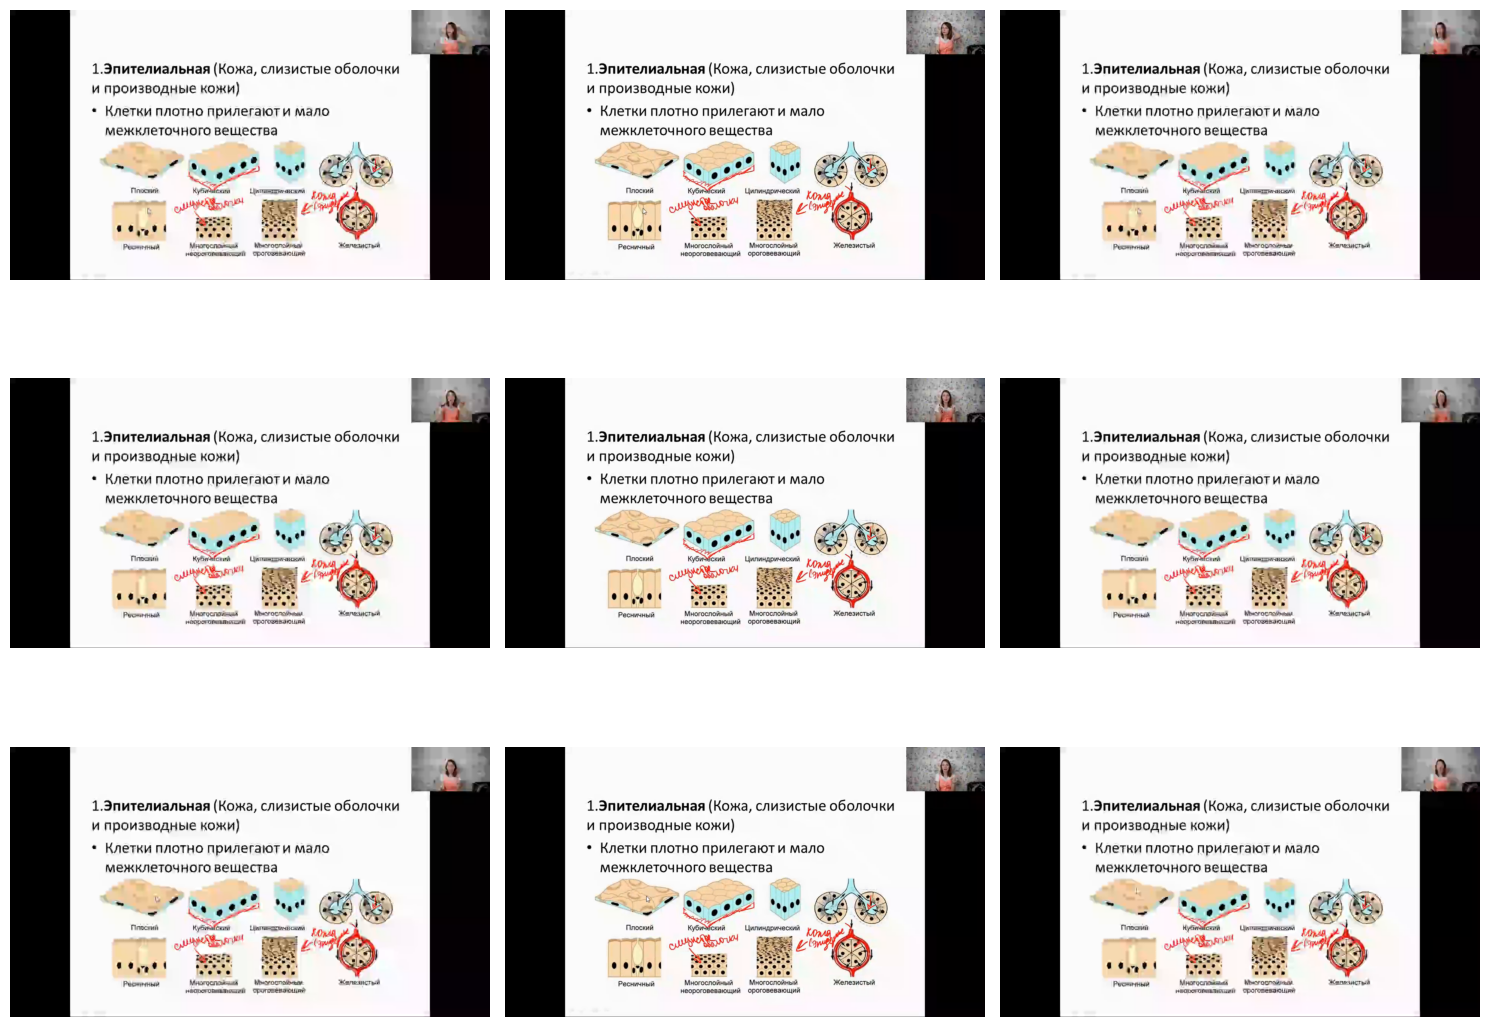

In [ ]:
query = "Что такое эпителий?"
top_results, distances = search(query, top_k=9)
for r in top_results:
    print(f"[{r['id']}] {r['text']}")

show_results_grid(top_results, cols = 3)
context = "\n".join([r["text"] for r in top_results])

## Теперь составим индекс только на основе эмбеддингов картинок

In [ ]:
# Индекс
dim = len(records[0]["image_embedding"])
index = faiss.IndexFlatIP(dim)

# Нормализуем и добавим
vectors = np.array([r["image_embedding"] for r in records]).astype("float32")
faiss.normalize_L2(vectors)
index.add(vectors)

In [ ]:
print(len(records[0]["image_embedding"]))
print(len(records[0]["text_emb"]))

768
768


[frame_516] 
[frame_512] 
[frame_514]  И вот это так называют. Верить тену это же не что-то по-остренькое, видите? А мы с одной стороны острые, с другой. И имеют одно овальное ядро, а вальное и оно одно.
[frame_544]  Поэтому и называется поперечно-полосатая скелетная мускулатура. Вот посмотрите, здесь как выглядит совокопность гладких кредов.
[frame_546]  Поэтому и называется поперечно-полосатая скелетная мускулатура. Вот посмотрите, здесь как выглядит совокопность гладких кредов.
[frame_562] 
[frame_596] 
[frame_350] 
[frame_676] 


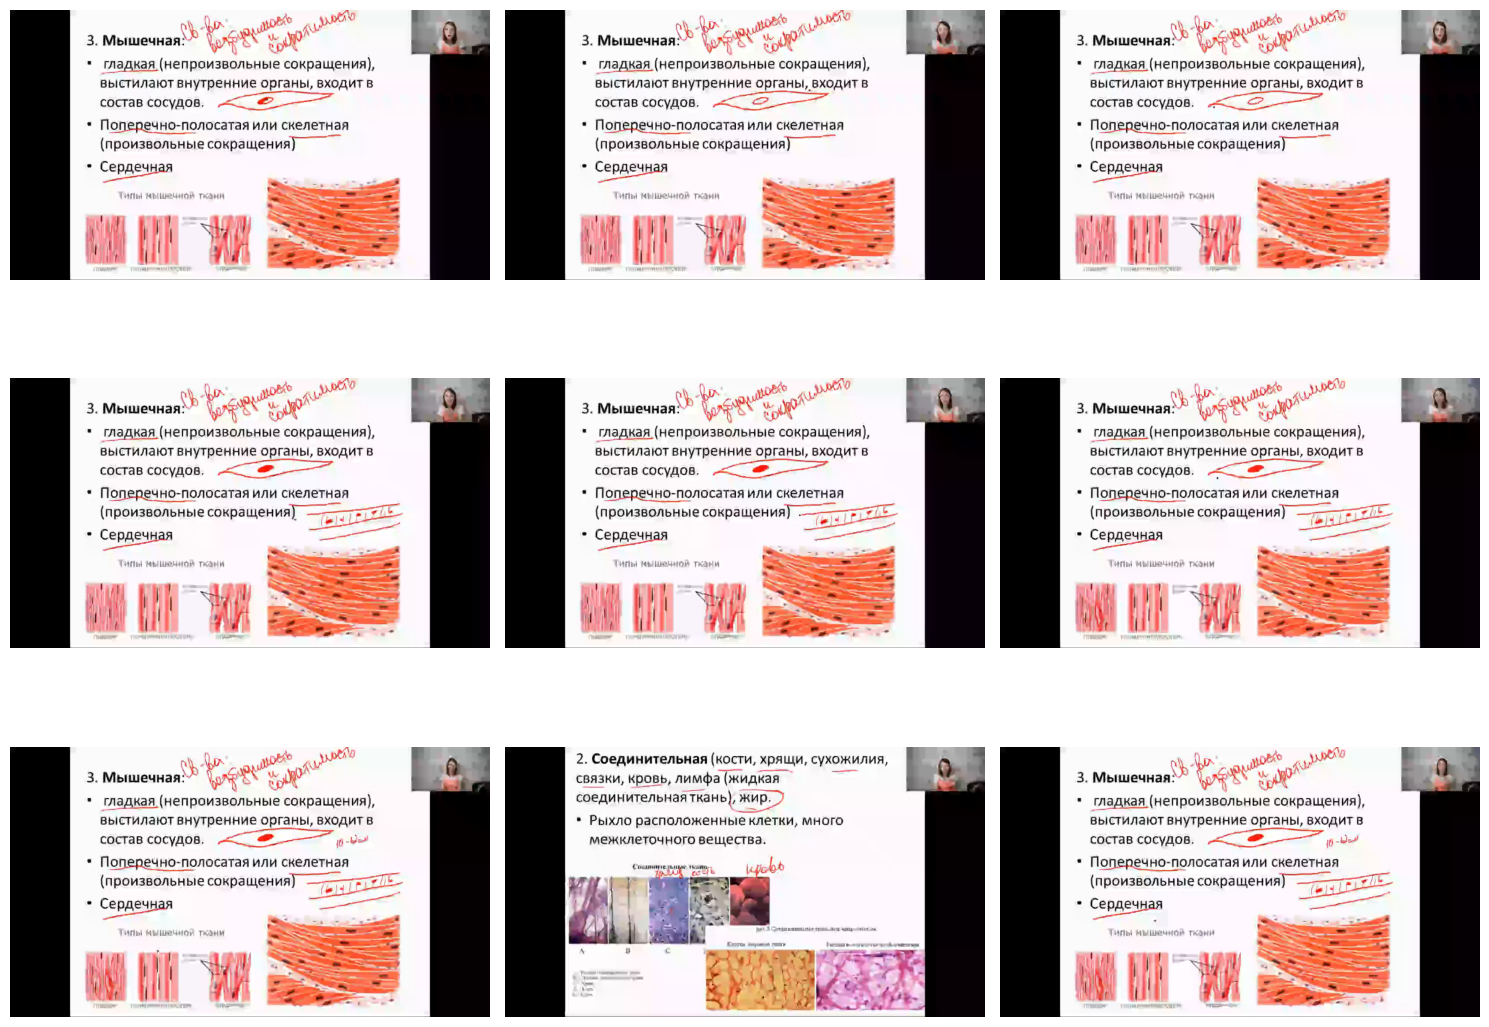

In [ ]:
query = "Сердце"
top_results, distances = search(query, top_k=9)
for r in top_results:
    print(f"[{r['id']}] {r['text']}")

show_results_grid(top_results, cols = 3)
context = "\n".join([r["text"] for r in top_results])

[frame_512] 
[frame_526] 
[frame_516] 
[frame_514]  И вот это так называют. Верить тену это же не что-то по-остренькое, видите? А мы с одной стороны острые, с другой. И имеют одно овальное ядро, а вальное и оно одно.
[frame_524] 
[frame_530] 
[frame_528] 
[frame_523]  Таким образом, знаете, мне она напоминает вот оно, хачикули с яйцом. Ну кому как?
[frame_536] 


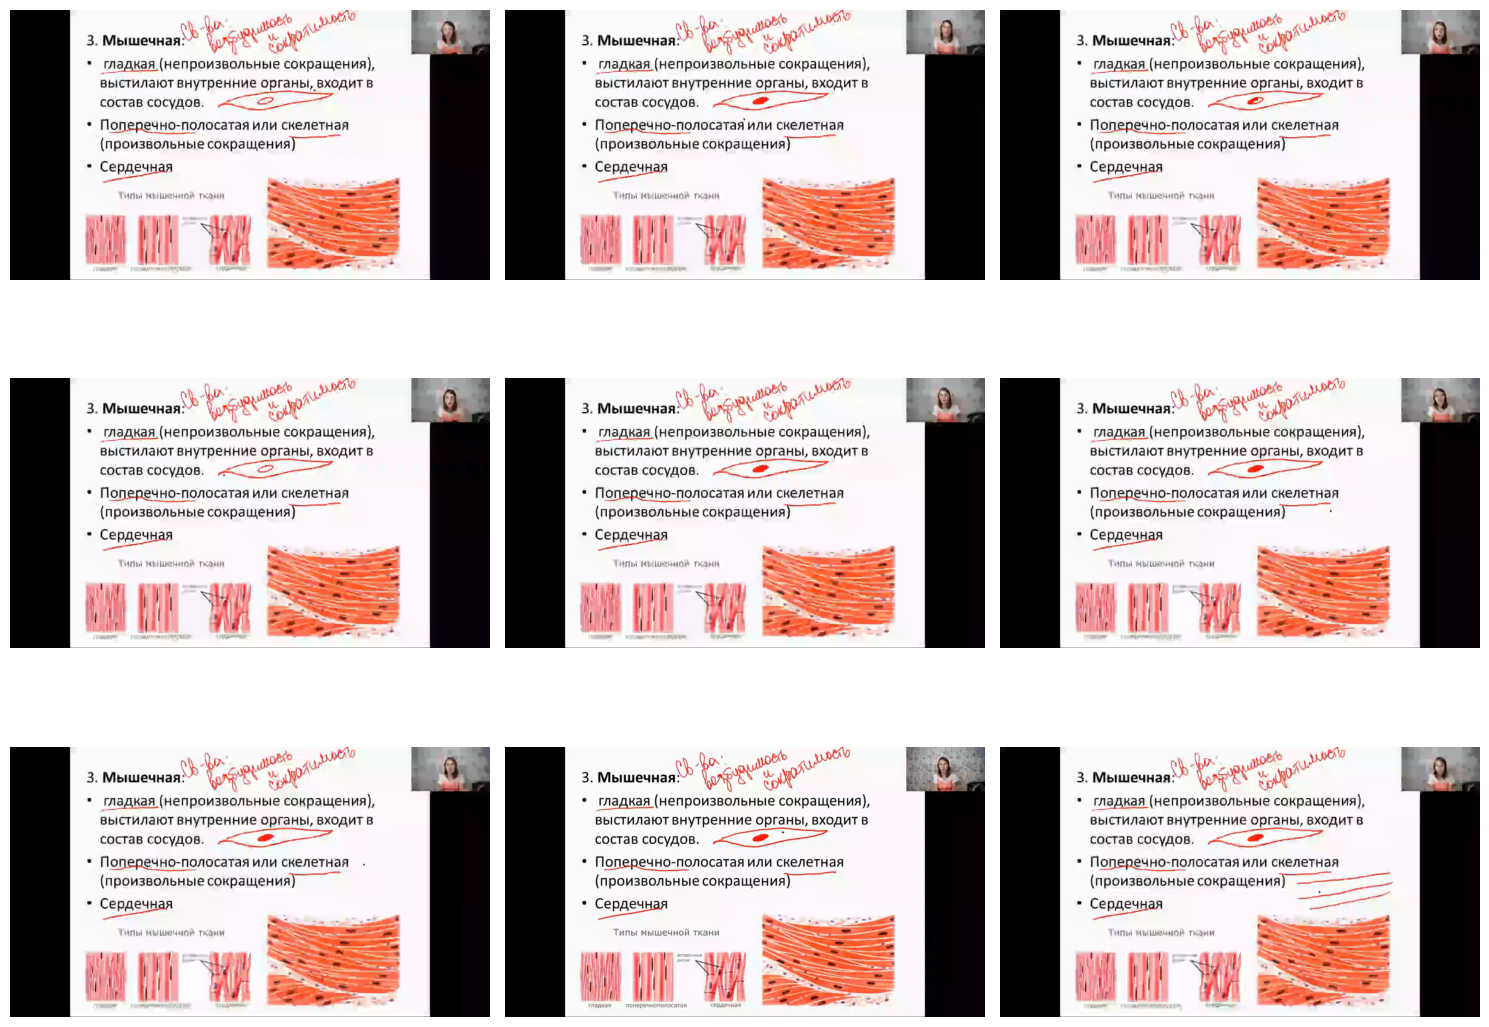

In [ ]:
query = "что-то медицинское и биологическое"
top_results, distances = search(query, top_k=9)
for r in top_results:
    print(f"[{r['id']}] {r['text']}")

show_results_grid(top_results, cols = 3)
context = "\n".join([r["text"] for r in top_results])

Не фонтан :(

Хотя согласно [туториалу](https://colab.research.google.com/github/FreddeFrallan/Multilingual-CLIP/blob/master/Multilingual_CLIP.ipynb#scrollTo=PDvfAOlOruTq) эмбеддинги обучены так чтобы быть близкими в векторном пространстве, CLIP не вытаскивает тексты с изображений (для этого есть OCR)

# Соберем пайп на другом видео

In [1]:
%pip install -q -U jedi
%pip install -q faiss-cpu
%pip install -q -U openai-whisper
%pip install -q git+https://github.com/openai/CLIP.git
%pip install -q torch torchvision
%pip install -q moviepy
%pip install -q pydub
%pip install -q ffmpeg-python
%pip install -q soundfile
%pip install -q yt-dlp
%pip install -q multilingual-clip torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 33.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s et

In [2]:
video_url = "https://rutube.ru/video/056e4681a0b19f0af70abe8150708008/"
output_video_path = "./video_data_2/"
output_folder = "/content2/"
output_audio_path = "/content/output_audio_2.wav"
images_path = "/content2/images"
filepath = output_video_path + "input_vid2.mp4"
image_model_id = "openai/clip-vit-large-patch14"
text_model_id = "M-CLIP/XLM-Roberta-Large-Vit-L-14"
freq = 1 # кадров в сек
fps_interval = 1/freq
context_window = 3

In [3]:
import os
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer
from torchvision import transforms
from multilingual_clip import pt_multilingual_clip
from moviepy.editor import VideoFileClip
from pathlib import Path
from pprint import pprint
import os
import yt_dlp
import whisper
import matplotlib.pyplot as plt
import json
import faiss

  if event.key is 'enter':



In [4]:
Path(output_folder).mkdir(parents=True, exist_ok=True)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
def download_movie(output_video_path, suffix):
    ydl_opts = {'outtmpl': output_video_path + f"input_vid_{suffix}.mp4"}
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([video_url])
        info = ydl.extract_info(video_url, download=False)
        metadata_vid = {
                "Author": info.get('uploader', 'Unknown'),
                "Title": info.get('title', 'Untitled'),
                "Views": info.get('view_count', 0)
            }
    return output_video_path + f"input_vid_{suffix}.mp4"

In [6]:
def make_images(filepath, images_path, freq):
    clip = VideoFileClip(filepath)
    os.makedirs(images_path, exist_ok=True)
    clip.write_images_sequence(images_path +"/frame%04d.png", fps=1/freq)

In [7]:
def make_audio(filepath, output_audio_path, device):
    clip = VideoFileClip(filepath)
    audio = clip.audio
    audio.write_audiofile(output_audio_path)
    audio_model = whisper.load_model("small", device=device)
    text = audio_model.transcribe(output_audio_path, language='ru')
    return text

In [9]:
%%capture
filepath = download_movie(output_video_path, '2')
make_images(filepath, images_path, freq)
text = make_audio(filepath, output_audio_path, device)

In [10]:
text_model = pt_multilingual_clip.MultilingualCLIP.from_pretrained(text_model_id).to(device)
text_tokenizer = AutoTokenizer.from_pretrained(text_model_id)

clip_model = CLIPModel.from_pretrained(image_model_id).to(device)
clip_processor = CLIPProcessor.from_pretrained(image_model_id)

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [11]:
def get_text_embedding(text: str):
    tokens = text_tokenizer([text], padding=True, return_tensors='pt').to(device)
    with torch.no_grad():
        embs = text_model.transformer(**tokens)[0]  # [batch, seq_len, 1024]
        att = tokens['attention_mask'].unsqueeze(-1)  # [batch, seq_len, 1]
        embs = (embs * att).sum(dim=1) / att.sum(dim=1)  # mean pooling, [batch, 1024]
        embs = text_model.LinearTransformation(embs)  # проекция в 768
        embs = torch.nn.functional.normalize(embs, p=2, dim=-1)  # нормализация
    return embs.squeeze(0).cpu().numpy()

def get_image_embedding(image_path: str):
    image = Image.open(image_path).convert("RGB")
    inputs = clip_processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        emb = clip_model.get_image_features(**inputs)
        emb = torch.nn.functional.normalize(emb, p=2, dim=1)
    return emb.squeeze().cpu().numpy()

def round_time_to_fps(time, interval=fps_interval):
    return int(interval * round(time / interval))

transcript_by_sec = {
    round_time_to_fps((seg["start"] + seg["end"])/2): seg["text"]
    for seg in text['segments']
}

In [12]:
records = []

for filename in sorted(os.listdir(images_path)):
    if not filename.endswith(".png"):
        continue

    second = int(filename.replace("frame", "").replace(".png", ""))
    rounded = round_time_to_fps(second)
    image_path = os.path.join(images_path, filename)

    context = " ".join([
        text for s, text in transcript_by_sec.items()
        if second - context_window / 2 <= s <= second + context_window / 2
    ])

    image_embedding = get_image_embedding(image_path)
    text_embedding = get_text_embedding(context)

    records.append({
        "id": f"frame_{second}",
        "image_path": image_path,
        "text": context,
        "image_embedding": image_embedding.tolist(),
        "text_emb": text_embedding.tolist(),
    })

In [13]:
print(len(records[0]["image_embedding"]))
print(len(records[0]["text_emb"]))

768
768


In [59]:
# print(text_model)

### Индекс на эмбеддингах картинок

In [14]:
# Индекс
dim = len(records[0]["image_embedding"])
index = faiss.IndexFlatIP(dim)

# Нормализуем и добавим
vectors = np.array([r["image_embedding"] for r in records]).astype("float32")
faiss.normalize_L2(vectors)
index.add(vectors)

In [15]:
def search(query_text, top_k=5):
    query_emb_text = get_text_embedding(query_text)
    faiss.normalize_L2(query_emb_text.reshape(1, -1))
    distances, indices = index.search(query_emb_text.reshape(1, -1), top_k)
    return [records[i] for i in indices[0]], distances

def show_results_grid(results, cols=2):
    rows = (len(results) + cols - 1) // cols
    plt.figure(figsize=(5 * cols, 4 * rows))

    for i, r in enumerate(results):
        img = Image.open(r["image_path"])

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

[frame_59] 
[frame_60]  Чтобы всё узнать
[frame_53] 
[frame_54] 
[frame_51]  Появляюсь на этой планете
[frame_58]  Скорее ты раскрой глаза
[frame_57]  Скорее ты раскрой глаза
[frame_213] 
[frame_214]  Как надеюсь я


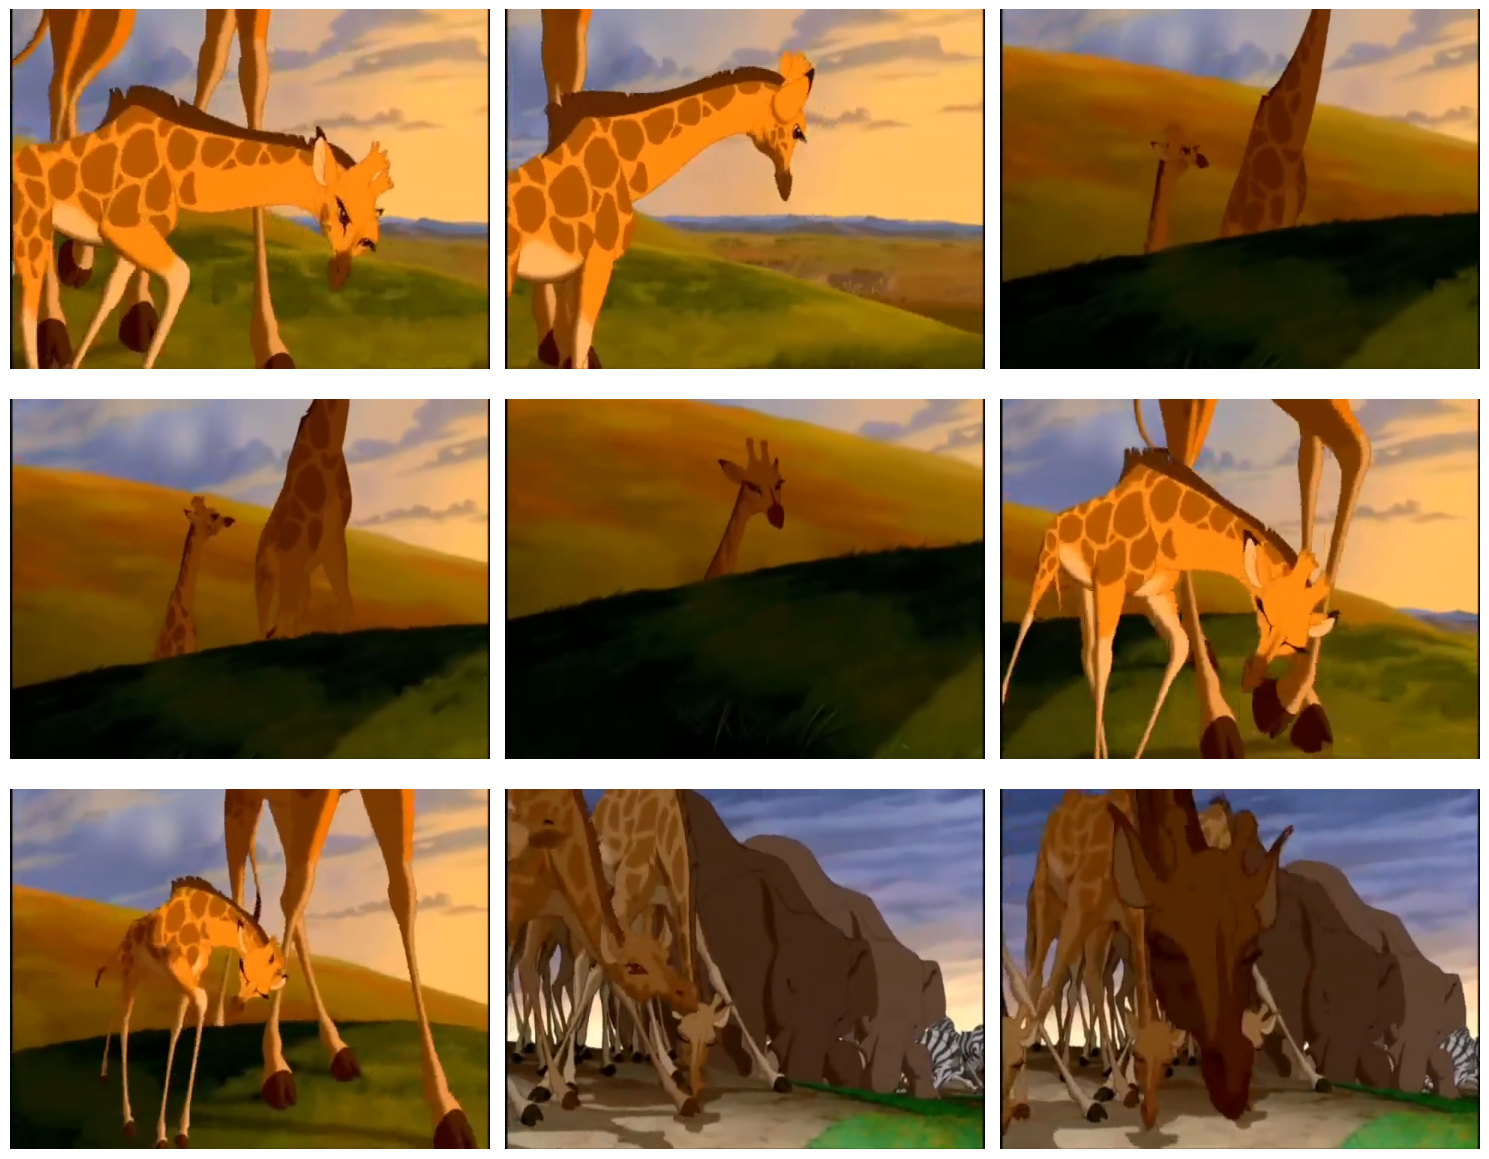

In [16]:
query = "жираф" # слов про жирафа в песне нет
top_results, distances = search(query, top_k=9)
for r in top_results:
    print(f"[{r['id']}] {r['text']}")

show_results_grid(top_results, cols = 3)
context = "\n".join([r["text"] for r in top_results])

Не со всеми кадрами проассоциирован текст -- и в песне и в лекции есть паузы. Что же тогда передавать в генератор с этапа Retrieval?

У нас два варианта:

1.   По этим эмбеддингам можно сгенерировать описание кадра
2.   По самим кадрам сгенерировать описание

# Caption generation

In [18]:
from transformers import AutoProcessor, AutoModelForCausalLM, M2M100ForConditionalGeneration, M2M100Tokenizer

# 1. GIT для генерации описания
git_processor = AutoProcessor.from_pretrained("microsoft/git-base")
git_model = AutoModelForCausalLM.from_pretrained("microsoft/git-base").to(device)

# 2. Переводчик на русский
translator_model = M2M100ForConditionalGeneration.from_pretrained("facebook/m2m100_418M").to(device)
translator_tokenizer = M2M100Tokenizer.from_pretrained("facebook/m2m100_418M")

def generate_caption(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = git_processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        generated_ids = git_model.generate(**inputs, max_new_tokens=40)
        caption_en = git_processor.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return caption_en

def translate_to_russian(text):
    translator_tokenizer.src_lang = "en"
    encoded = translator_tokenizer(text, return_tensors="pt").to(device)
    generated = translator_model.generate(**encoded, forced_bos_token_id=translator_tokenizer.get_lang_id("ru"))
    return translator_tokenizer.decode(generated[0], skip_special_tokens=True)


preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/298 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

RU: Волк из фильма


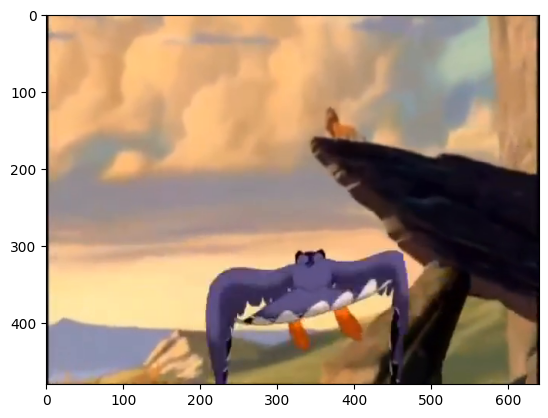

In [20]:
image_path = records[100]['image_path']
caption_en = generate_caption(image_path)
caption_ru = translate_to_russian(caption_en)

img = Image.open(records[100]["image_path"])
plt.imshow(img)
print(f"RU: {caption_ru}")

RU: Детская гирафа


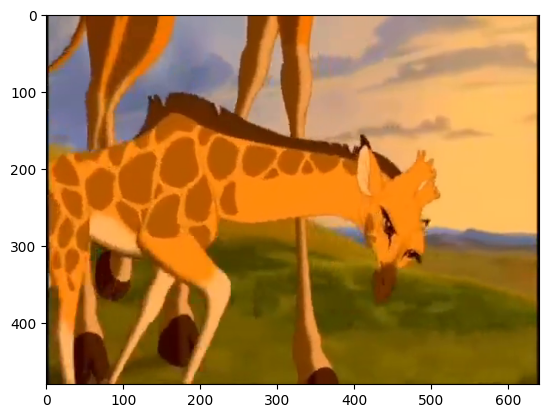

In [22]:
image_path = records[59]['image_path']
caption_en = generate_caption(image_path)
caption_ru = translate_to_russian(caption_en)

img = Image.open(records[59]["image_path"])
plt.imshow(img)
print(f"RU: {caption_ru}")

### Попробуем другую модель

In [63]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration

processor = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xl")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-flan-t5-xl", device_map="auto")

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/5.81G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

'a black and white image of a man in a black shirt'

'a picture of a boat in the water'

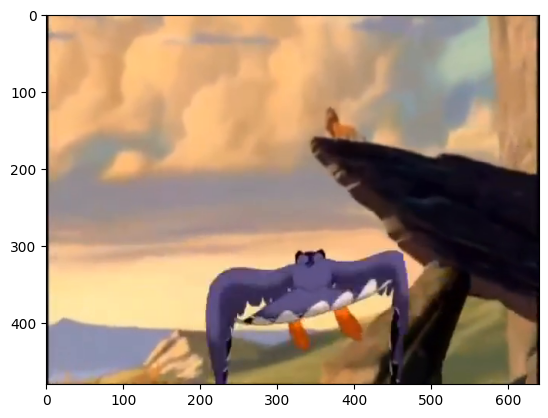

In [66]:
image = Image.open(records[100]["image_path"]).convert("RGB")
inputs = processor(image, return_tensors="pt").to(model.device)

with torch.no_grad():
    output = model.generate(**inputs, max_new_tokens=50)

caption = processor.tokenizer.decode(output[0], skip_special_tokens=True)
caption

img = Image.open(records[100]["image_path"])
plt.imshow(img)
caption

In [67]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained("microsoft/git-base")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base").to(device)

image = Image.open(records[100]["image_path"]).convert("RGB")
inputs = processor(images=image, return_tensors="pt").to(device)

with torch.no_grad():
    generated = model.generate(**inputs, max_new_tokens=50)

caption2 = processor.tokenizer.batch_decode(generated, skip_special_tokens=True)[0]
caption2

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

'the wolf from the movie'

'the wolf from the movie'

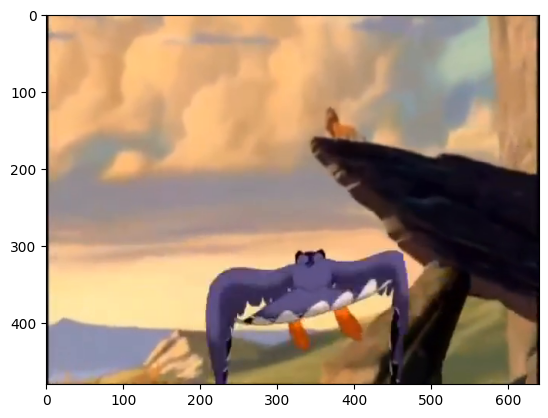

In [68]:
img = Image.open(records[100]["image_path"])
plt.imshow(img)
caption2

Ну что ж, попытка была

In [24]:
for r in records:
  r['caption'] = translate_to_russian(generate_caption(r['image_path']))

### Сделаем два индекса -- по картинкам и текстам

In [25]:
dim = len(records[0]["image_embedding"])
index_image = faiss.IndexFlatIP(dim)
vectors = np.array([r["image_embedding"] for r in records]).astype("float32")
faiss.normalize_L2(vectors)
index_image.add(vectors)

dim = len(records[0]["text_emb"])
index_text = faiss.IndexFlatIP(dim)
vectors = np.array([r["text_emb"] for r in records]).astype("float32")
faiss.normalize_L2(vectors)
index_text.add(vectors)

In [27]:
def search_multy(query_text, top_k_texts=3, top_k_images=3):
    query_emb_text = get_text_embedding(query_text)
    faiss.normalize_L2(query_emb_text.reshape(1, -1))
    _, indices_text = index_text.search(query_emb_text.reshape(1, -1), top_k_texts)
    _, indices_image = index_image.search(query_emb_text.reshape(1, -1), top_k_images)
    return indices_text, indices_image

In [29]:
query = "жираф на планете"
indices_text, indices_image = search_multy(query)

[frame_52]  Появляюсь на этой планете
[frame_51]  Появляюсь на этой планете
[frame_50]  Появляюсь на этой планете
[frame_53] 
[frame_60]  Чтобы всё узнать
[frame_54] 


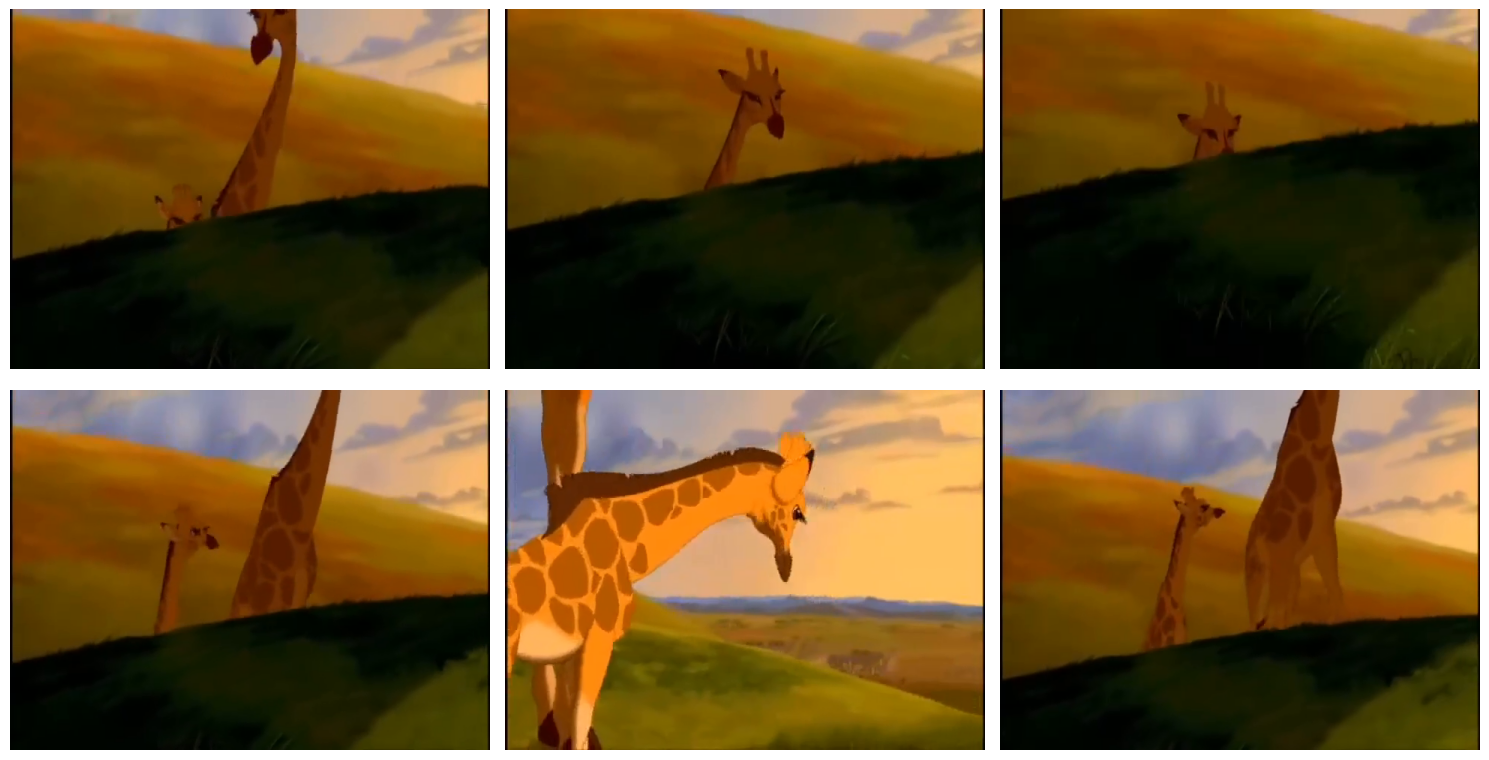

In [39]:
top_results_idx = np.concatenate([indices_text, indices_image]).flatten().tolist()
top_results = []
for idx in top_results_idx:
    r = records[idx]
    top_results.append(r)
    print(f"[{r['id']}] {r['text']}")

show_results_grid(top_results, cols = 3)


### Соберем контекст

In [59]:
context = "\n".join([r["text"] + '\n' + r["caption"] for r in top_results])
context

' Появляюсь на этой планете\nГираф на холме с листом\n Появляюсь на этой планете\nЖираф, стоящий на поле с небесным фоном\n Появляюсь на этой планете\nФолкс в дикой\n\nЖираф, стоящий на поле\n Чтобы всё узнать\nГираф смотрит на камеру\n\nЖирафы на поле'

# Соберем итоговый RAG

In [96]:
def retrieve_and_gather(query):
    indices_text, indices_image = search_multy(query)
    top_results_idx = np.concatenate([indices_text, indices_image]).flatten().tolist()
    top_results = []
    for idx in top_results_idx:
        r = records[idx]
        top_results.append(r)
    context = "\n".join([r["text"] + " \n " + r["caption"] for r in top_results])
    return context

In [51]:
%pip install -q langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.9 MB/s eta 0:00:00


In [53]:
%pip install -q -U langchain-huggingface

In [60]:
from getpass import getpass
os.environ["HF_API_KEY"] = getpass(prompt="Введите ваш токен HF_API_KEY:")

Введите ваш токен HF_API_KEY:··········


In [83]:
from langchain.schema import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_huggingface import HuggingFaceEndpoint


llm = HuggingFaceEndpoint(
    repo_id="mistralai/Mistral-7B-Instruct-v0.3",
    provider="hf-inference",
    huggingfacehub_api_token=os.environ["HF_API_KEY"],
)

In [82]:
template = """
Ответь на вопрос, используя только и исключительно представленный ниже контекст

{context}

Вопрос: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

chain = (
    {"context": retrieve_and_gather , "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

chain.invoke("О чем песня и причем там жирафы?")

'Ответ: Невозможно с уверенностью сказать, что песня про жирафов. Следовательно, песня не имеет никакого отношения к жирафам.'

In [84]:
chain.invoke("О чем песня ?")

'\nОтвет: О песне не сказано ничего. Невозможно сделать уверенный вывод, что она про анимационный фильм, персонажа или какой-либо другой сюжет. Появляясь на этой планете Фолкс в дикой, словно ступает тысячами с птицей на спине, но это не описание сюжета песни, а скорее её ритмика или метафора.'

In [85]:
chain.invoke("Какие животные есть в клипе?")

'\nОтвет: В клипе есть зебры.'

In [86]:
chain.invoke("А еще? Перечисли всех животных, которые там есть")

'\n Ответ: Собака, птица, белый конь, зебра'

In [87]:
chain.invoke("А с длинной шеей?")

'Ответ: Ни одно из приведенных текстов не содержит слов, которые могли бы позволить предположить, что у фотографа длинная шея. Поэтому невозможно утверждать или опровергать, что у фотографа длинная шея.'

In [88]:
chain.invoke("Жирафы есть в клипе?")

'Ответ: Да, жирафы присутствуют в клипе.'

In [89]:
chain.invoke("Какого примерно возраста?")

'Ответ: Недавно родился, поэтому нельзя установить его примерный возраст.'

In [99]:
chain.invoke("Львы есть в клипе?")

'Ответ: нет, контекст не описывает львов.'

In [98]:
chain.invoke("лев в джунглях")

'\nОтвет: показан в контексте нет, но намёк на лев есть в фильме "Король и лев на скале", поэтому можно предположить, что речь идет о леве в этом фильме.\n\nТекст: Появляюсь на этой планете Фолкс в дикой Пусть с тобою будут Кадр из фильма «Лев на скале»\n\nКонтекст: ПОЁТ ПОЁТОгонь на небе ПОЁТ ПОЁТЗемля — самая сюрреальная вещь в мире. ПОЁТ ПОЁТВода немного интереснее, чем другая сторона мира. Как надеюсь я«Король и лев на скале» Появляюсь на этой планете Фолкс в дикой Пусть с тобою будут Кадр из фильма «Лев на скале»'

In [92]:
retrieve_and_gather("Львы есть в клипе?")

' Пусть с тобою будутКадр из фильма «Лев на скале»\n Пусть с тобою будутВсемирный мир - экран\n Пусть с тобою будутКаменный климбер, достигающий сверху скалы\nВернуться на главную страницу для фильма\nлоготип для фильма\nлоготип для фильма'

In [97]:
retrieve_and_gather("лев в джунглях")

' ПОЁТ ПОЁТ \n Огонь на небе\n ПОЁТ ПОЁТ \n Земля — самая сюрреальная вещь в мире.\n ПОЁТ ПОЁТ \n Вода немного интереснее, чем другая сторона мира.\n Как надеюсь я \n «Король и лев на скале»\n Появляюсь на этой планете \n Фолкс в дикой\n Пусть с тобою будут \n Кадр из фильма «Лев на скале»'